<p style="text-align:left;">
    <font size="6">Part1</font>
    <span style="float:right;">
        Aqsa Mahmood
    </span>
</p>

# <center>On Educational Media And Learning Process</center>

## 1 Data Description

I have decided to participate in the <a href="https://www.kaggle.com/c/data-science-bowl-2019/data"> kaggle comptetion </a> namely 2019 Data Science Bowl ,wherby the objective is to uncover the factors to help measure how young children learn.he intent of the competition is to use the gameplay data (from PBS KIDS Measure Up! app) to predict how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt).In the app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. 
The outcomes of this task are grouped into 4 groups (labeled `accuracy_group` in the data):

- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved


## 2 Research Questions
•	Which game factors have positive or negative impact on the player’s performance in the assessment?  
•	Which features are helpful to identify the complexity of each assessment?  
•	Classifying the number of users according to the number of attempts they took to pass an assessment?  


## 3 Loading the Data  

### 3.1 Importing Libraries

In [178]:
import warnings
warnings.filterwarnings('ignore')
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns 

from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats

from sklearn.model_selection import GroupKFold
from typing import Any
from numba import jit

from sklearn import metrics
from itertools import product
from sklearn import preprocessing

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### 3.2 Data Loading and Inspection

In [179]:
# Load datasets, obtained from the kaggle website
train_data=pd.read_csv('train.csv')
trainLabels = pd.read_csv('train_labels.csv')
specs_data = pd.read_csv('specs.csv')

In [180]:
# Display info of datasets
print('The train dataframe has {} rows and {} columns'.format(train_data.shape[0], train_data.shape[1]))
print('The trainLabels dataframe has {} rows and {} columns'.format(trainLabels.shape[0], trainLabels.shape[1]))
print('The specs_data dataframe has {} rows and {} columns'.format(specs_data.shape[0], specs_data.shape[1]))


The train dataframe has 11341042 rows and 11 columns
The trainLabels dataframe has 17690 rows and 7 columns
The specs_data dataframe has 386 rows and 3 columns


## 4 Data Preprocessing

### 4.1 Train Data

In [181]:
train_data.head(3)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [182]:
#Inspecting the type of variables and memory usage of the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
dtypes: int64(3), object(8)
memory usage: 951.8+ MB


In [183]:
train_int = train_data.select_dtypes(include=['int64'])
train_int.describe()

,event_count,event_code,game_time
count,1.134104e+07,1.134104e+07,1.134104e+07
mean,1.056642e+02,3.513838e+03,1.976236e+05
std,1.483477e+02,6.816470e+02,1.803968e+06
min,1.000000e+00,2.000000e+03,0.000000e+00
25%,2.500000e+01,3.021000e+03,3.061800e+04
50%,6.100000e+01,4.020000e+03,7.276100e+04
75%,1.290000e+02,4.035000e+03,1.574460e+05
max,3.368000e+03,5.010000e+03,3.069102e+08


In [184]:
train_obj = train_data.select_dtypes(include=['object'])
train_obj.describe()

,event_id,game_session,timestamp,event_data,installation_id,title,type,world
count,11341042,11341042,11341042,11341042,11341042,11341042,11341042,11341042
unique,384,303319,10777308,10893749,17000,44,4,4
top,1325467d,6e6e697f2e593de1,2019-08-01T20:08:13.052Z,"{""event_code"": 2000, ""event_count"": 1}",f1c21eda,Chow Time,Game,MAGMAPEAK
freq,274673,3368,11,183676,58988,1150974,5795293,5023687


In [185]:

#Transform 'timestamp' into a 'YYYY-MM-DD' datetime format and extract all the required feature as new Column.
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'], format = "%Y-%m-%d %H:%M:%S")
train_data['Hour'] = train_data['timestamp'].dt.hour
train_data['Month'] = train_data['timestamp'].dt.month_name()
train_data['day_name'] = train_data['timestamp'].dt.day_name()
train_data['Date'] = train_data['timestamp'].dt.date
train_data['Date'] = train_data['Date'].astype('datetime64[D]')
train_data.dtypes.to_frame().T



,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,Hour,Month,day_name,Date
0,object,object,"datetime64[ns, UTC]",object,object,int64,int64,int64,object,object,object,int64,object,object,datetime64[ns]


In [186]:
# check unique codes in event code column
train_data.event_code.nunique()

42

In [187]:
train_data[['event_code', 'title', 'type', 'world', 'Hour', 'Month', 'day_name']] =train_data[['event_code', 'title', 'type', 'world', 'Hour', 'Month', 'day_name']].astype('category')
train_data[['event_count']] =train_data[['event_count']].astype('uint16')
train_data[['game_time']]=train_data[['game_time']].astype('uint32')

In [188]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 15 columns):
event_id           object
game_session       object
timestamp          datetime64[ns, UTC]
event_data         object
installation_id    object
event_count        uint16
event_code         category
game_time          uint32
title              category
type               category
world              category
Hour               category
Month              category
day_name           category
Date               datetime64[ns]
dtypes: category(7), datetime64[ns, UTC](1), datetime64[ns](1), object(4), uint16(1), uint32(1)
memory usage: 659.8+ MB


In [189]:
# To check missing values in train_data
train_data.isnull().sum()
"""There is not any missing value in data"""

'There is not any missing value in data'

**Comment**

There are 17000 unique installation Ids, 303319 unique game sessions, 44 titles, 4 media types and 4 worlds."Title", "Type" and "World" are nominal categorical features.The type of title, type and world has been changed from object to category. Also, we have changed the type of "event code" to category as it has 42 unique event codes which  provides us  the information about each action taken by player. Start of the each game session has event code 2000.

We have extracted features(Hour,Date, Month, Day-Name) from timestamp to support our analysis.

To work with large dataset more efficiently, we have change the type of "int64" to "uint32/uint16" according to the range of the values in each numeric column. By doing this, memory usage have been reduced from 951MB to 651MB. 

### 4.2 Train Labels

In [190]:
trainLabels.head(3)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3


In [191]:
trainLabels.info()
#There is not any missing value in train labels data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int64
num_incorrect      17690 non-null int64
accuracy           17690 non-null float64
accuracy_group     17690 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 967.5+ KB


In [192]:
trainLabels_int = trainLabels.select_dtypes(include=['int64', 'float64']).copy()
trainLabels_int.describe()

,num_correct,num_incorrect,accuracy,accuracy_group
count,17690.000000,17690.000000,17690.000000,17690.000000
mean,0.760938,1.587790,0.595810,1.885585
std,0.426523,3.058295,0.430559,1.256796
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.111111,1.000000
50%,1.000000,0.500000,0.750000,2.500000
75%,1.000000,2.000000,1.000000,3.000000
max,1.000000,85.000000,1.000000,3.000000


In [193]:
trainLabels_obj = trainLabels.select_dtypes(include=['object']).copy()
trainLabels_obj.describe()

,game_session,installation_id,title
count,17690,17690,17690
unique,17690,3614,5
top,7bab771f90442eb1,08987c08,Cart Balancer (Assessment)
freq,1,156,4151


In [194]:
# transform categorical variabes into pandas category type
trainLabels[['title','num_correct', 'accuracy_group']] = trainLabels[['title','num_correct', 'accuracy_group']] .astype('category')
trainLabels[['num_incorrect', 'accuracy']] = trainLabels[['num_incorrect', 'accuracy']].astype('uint16')
trainLabels.dtypes.to_frame().T
# we changed the type of  nominal categorical columns from object to category as well as column with type int64 to uint 16 according to their range of values.

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,object,object,category,category,uint16,uint16,category


**Comment**


There are 3614 unique installation id's and 17690  game sessions in labels data. Train labels data has information about the outcomes of the assessments for the installaton ids who attempted an assessment. 
The purpose of this dataset is illustrate the creation of response variable `accuracy_group` and `accuracy` for each  assessment per 'installation_id'.

### 4.3 Specs Data

In [195]:
specs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 3 columns):
event_id    386 non-null object
info        386 non-null object
args        386 non-null object
dtypes: object(3)
memory usage: 9.1+ KB


In [196]:
specs_obj = specs_data.select_dtypes(include=['object']).copy()
specs_obj.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,7dfe6d8a,This event occurs when the player clicks on the help button. It contains information about the state of the game that caused the player to seek help. This event is usually followed by a 3010 (system-initiated instruction) event. It helps identify points that players feel are too difficult.,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""name"":""description"",""type"":""string"",""info"":""the text or description of the instruction""},{""name"":""identifier"",""type"":""string"",""info"":""a unique identifier for this piece of instruction""},{""name"":""media_type"",""type"":""string"",""info"":""the type of media that has just played:\n'audio' || 'animation' || 'other'""},{""name"":""duration"",""type"":""int"",""info"":""the duration of the media playback in milliseconds""},{""name"":""event_count"",""type"":""int"",""info"":""session event counter""},{""name"":""event_code"",""type"":""int"",""info"":""event class identifier""}]"
freq,1,17,25


In [197]:
specs_data.args[0]# args column has information about each argument name, type, and info.

'[{"name":"game_time","type":"int","info":"millisecond count since start of game"},{"name":"round","type":"int","info":"number of the current round when the event takes place or 0 if no round"},{"name":"level","type":"int","info":"number of the current level when the event takes place or 0 if no level"},{"name":"description","type":"string","info":"the text or description of the instruction"},{"name":"identifier","type":"string","info":"a unique identifier for this piece of instruction"},{"name":"media_type","type":"string","info":"the type of media that has just played:\\n\'audio\' || \'animation\' || \'other\'"},{"name":"duration","type":"int","info":"the duration of the media playback in milliseconds"},{"name":"event_count","type":"int","info":"session event counter"},{"name":"event_code","type":"int","info":"event class identifier"}]'

**comment**


Specs data contains information about 386 unique event ids. We will only use this dataset to get more information about the variable "event data" in train dataset.

Our work is mainly going to revolve around train data.

## 5 Understanding the train data

### 5.1 Installation Id

In [198]:
#How many installation id's took an assessment?
train_in= train_data[(train_data.type == 'Assessment')]
train_in.installation_id.nunique()
#There are 4242 unique installaion ids who took an assessment 

4242

In [199]:
#How many installation id's took assessments and have feedback(num_correct/num_incorrect)?
#number of attempts of assessments with their feedback are recorded in event_code 4100 & 4110.
train_as= train_data[(train_data.type == 'Assessment')&((train_data.event_code==4100)|(train_data.event_code==4110))]
train_as.installation_id.nunique()
#Only 3614 installation Ids  have outcome of  assessment in train data which is the same number of unique installation ids in train label data.

3614

In [200]:
#To check number of installation ids who took an assessment but didnt submitted thats why they dont have feedback(num_correct/num_incorrect)
a = train_as.installation_id.unique()
train_no = train_in[~train_in.installation_id.isin(a)]
train_no.installation_id.nunique()
# So there are 628 installation ids who took assessment but did not recorded them for feedback

628

In [201]:
# Removing useless installation ids from taining data
real_ids = trainLabels.installation_id.unique()
reduce_train = train_data[train_data.installation_id.isin(real_ids)]
print('Train Dataset now has shape of ', reduce_train.shape)

Train Dataset now has shape of  (7734558, 15)


In [202]:
#Checking for duplicated rows
reduce_train.duplicated().sum()

0

**Comment**

There are 4242 installation ids who took an assessment but only 3614 installation ids have resuts(accuracy group) for assessment  while other (628/4242) took an assessments but didnt submitted, so they dont have any feedback. 

Our analysis is only concerned about those installation ids who took an assessment and have outcome for assessment in train labels data. So we have removed all the other installation ids which has reduced the size of our data.


### 5.2 Data Visualization

#### Categorical Variables

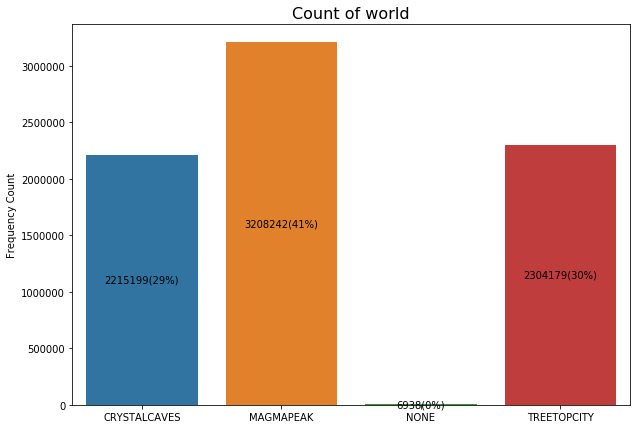

In [203]:
## WORLD
figure, world_bar = plt.subplots(figsize = (10,7))
sns.barplot(x =reduce_train["world"].value_counts().index, y = reduce_train["world"].value_counts(), ax = world_bar )
world_bar.set_ylabel('Frequency Count')
world_bar.set_title('Count of world', fontsize = 16)
for patch in world_bar.patches:
    label_x = patch.get_x() + patch.get_width()/2  
    label_y = patch.get_y() + patch.get_height()/2
    world_bar.text(label_x, label_y,
                
               str(int(patch.get_height())) + '(' +
               '{:.0%}'.format(patch.get_height()/len(reduce_train["world"]))+')',
               horizontalalignment='center', verticalalignment='center')
# Most of the players played MagmaPeak World.

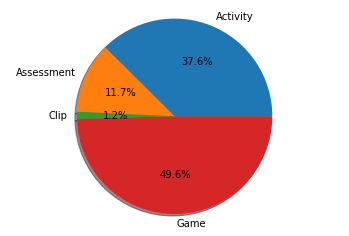

In [204]:
 # Type
labels = reduce_train['type'].cat.categories.tolist()
counts = reduce_train['type'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

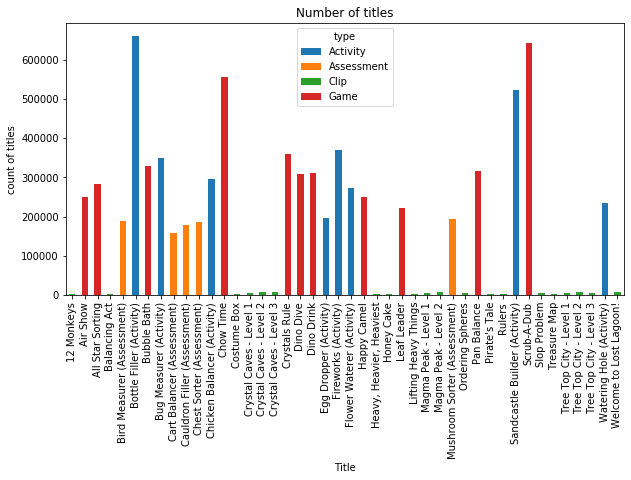

In [205]:
# Title for Game/Assessments/Clips/Activities
reduce_train.groupby(['title','type']).size().unstack().plot(kind='bar',stacked=True, figsize=(10,5))
plt.xlabel('Title')
plt.ylabel('count of titles')
plt.title('Number of titles')
plt.xticks(rotation=90);
plt.show()

In [206]:
# to check the overall number of Games 
g = reduce_train[(reduce_train.type=='Game')]

g.title.nunique()
#There are 11 games in the app.

11

In [207]:
# to check the overall number of Assesment
a = reduce_train[(reduce_train.type=='Assessment')]

a.title.nunique()
#There are 5 assessments in the app.

5

In [208]:
# to check the overall number of Activity
c = reduce_train[(reduce_train.type=='Activity')]

c.title.nunique()
#There are 8 activities in the app.

8

In [209]:
# to check the overall number of Clip 
b = reduce_train[(reduce_train.type=='Clip')]

b.title.nunique()
#There are 20 clips in the app.


20

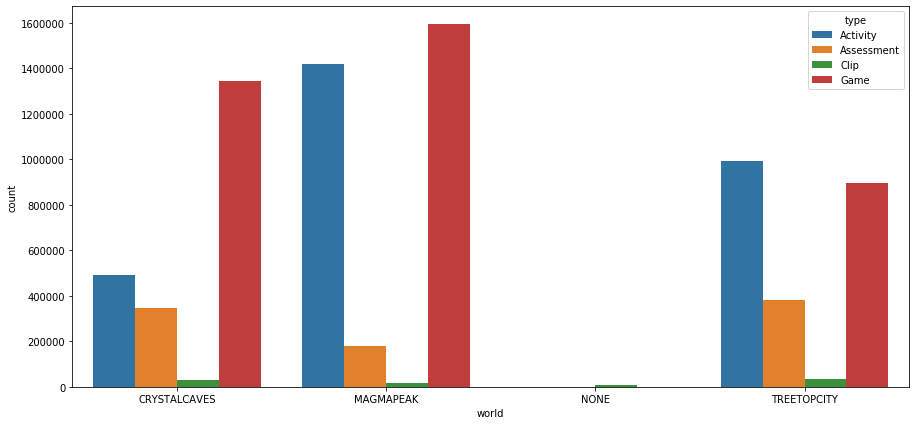

In [210]:
# To inspect which world has more number of games, activities, Clips and Assessments.
#Type and World
_, axes = plt.subplots(1, 1, sharey=True, figsize=(15, 7))

sns.countplot(x='world', hue='type', data = reduce_train, ax=axes);

**comment**

World column has four values namely "MagmaPeak", "TreeTopCity" , "CrystalCaves" and  "None". "None" is just the apps start screen and has only one Clip "Welcome To Lost Lagoon!". "MagmaPeak", "TreeTopCity", and "Crystal Caves" are three worlds.Magmapeak world has the most number of users. All of three worlds have four media types which are "Clip", "Activity","Game"  and "Assessment".Approximately 50%  kids played games and only  11% attempted assessments.So, Game is the most popular media type in this app.Overall there are 11 games,8 activities, 5 assessments and 20 clips in the app.Scrub-A-Dub, Chow Time are the most played games while Leaf Leader is the least played game.
Mushroom Sorter , Bird Measurer , Chest Sorter , Cauldron Filler  ,Cart Balancer are the titles of 5 assessments.      
Bottle Filler, Sandcastle Builder are the  most popular activities. 
The world Magmapeak and crystalcaves have more games than Treetopcity while treetopcity has more activities than other worlds. 


#### Timestamp

In [211]:
max(reduce_train.Date)

Timestamp('2019-10-14 00:00:00')

In [212]:
min(reduce_train.Date)

Timestamp('2019-07-23 00:00:00')

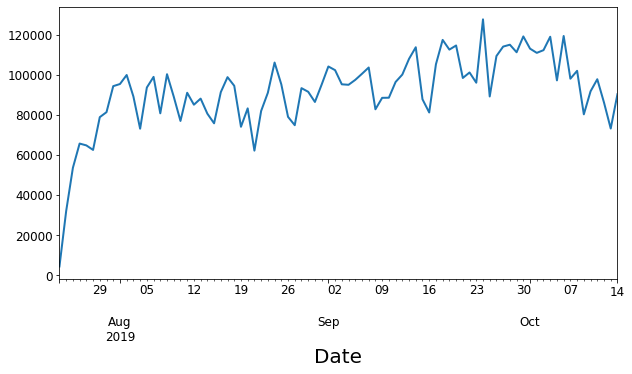

In [213]:
reduce_train.groupby('Date')['Date'].count().plot(figsize=(10,5), linewidth=2, fontsize=12)
plt.xlabel('Date', fontsize=20);


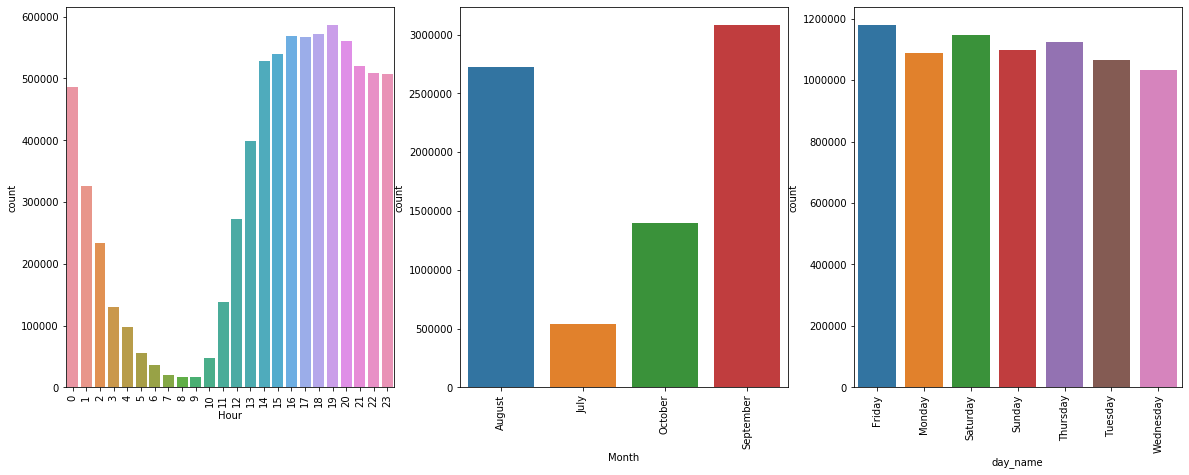

In [214]:

# Analyze the feature extracted from TimeStamp
variables = ['Hour', 'Month', 'day_name']
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
for values, subplot in zip(variables, ax.flatten()):
    sns.countplot(reduce_train[values], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

**Comment**

This data is from 23 july 2019 to 14 october 2019.It seems users were most active in september compared to other months. Most of the users used app between 4:00 and 8:00 o clock in a day.


### 5.3 Event_count

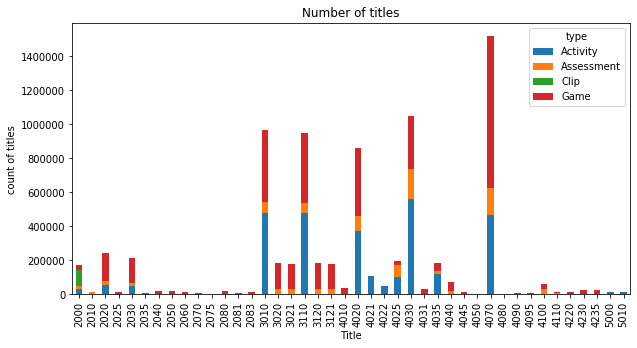

In [215]:
reduce_train.groupby(['event_code','type']).size().unstack().plot(kind='bar',stacked=True, figsize=(10,5))
plt.xlabel('Title')
plt.ylabel('count of titles')
plt.title('Number of titles')
plt.xticks(rotation=90);
plt.show()

In [216]:
sns.countplot(accuracy_group, hue = 'Assessment', data = trainLabels)

NameError: name 'accuracy_group' is not defined

**comment**


Event code 2000 represent the start of each media type.Clip has only event code 2000.According to the data description, event codes 4100  has feedback for all the assessment except bird measurer assessment which has outcome in event code 4110. The event code 4070 has been used by most of the users during game playing.

## 6 Label Encoding

The columns title, type and world are to be encoded using labelencoder, purely to increase performace during feature engineering.

In [217]:
class MultiColumnLabelEncoder:
    
    def __init__(self, columnsToEncode=['title','type','world']):
        self.columns = columnsToEncode # list of column to encode

    def transform(self,df,columnsToEncode=['title','type','world']):
        le = preprocessing.LabelEncoder()    
        obj_df = df.select_dtypes(include=['object','category']).copy()

        cols = columnsToEncode if columnsToEncode is not None else df.columns

        map_of_encoded_cols = {}
        for i in range(0,len(cols)):
            le.fit(obj_df[cols[i]].astype(str))
            print(le.classes_)
            map_of_encoded_cols[cols[i]] = dict(zip(le.classes_, le.transform(le.classes_)))

        obj_df[cols]=obj_df[cols].astype(str).apply(le.fit_transform)

        int_df = df.select_dtypes(include=['int64','uint32','uint16']).copy()
        float_df=df.select_dtypes(include=['float64']).copy()
        df_int_float = pd.concat([float_df,int_df], axis=1, join_axes=[int_df.index])
        df_final = pd.concat([df_int_float,obj_df], axis=1, join_axes=[df_int_float.index])

        win_code2 = dict(zip(map_of_encoded_cols['title'].values(), (4100*np.ones(len(obj_df[['title']]))).astype('int')))

        # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
        win_code2[ map_of_encoded_cols['title'].get('Bird Measurer (Assessment)')] = 4110

        # convert time  into datetime
        df_final['timestamp'] = pd.to_datetime(df['timestamp'])

        return df_final, win_code2,map_of_encoded_cols    

In [218]:
df = reduce_train
df = df.drop(columns = ["Hour", "Month", "day_name", "Date"])

In [219]:
encoder = MultiColumnLabelEncoder( columnsToEncode=['title','type','world'])
train_encoded_df,win_code,encoded_map = encoder.transform(df)

['12 Monkeys' 'Air Show' 'All Star Sorting' 'Balancing Act'
 'Bird Measurer (Assessment)' 'Bottle Filler (Activity)' 'Bubble Bath'
 'Bug Measurer (Activity)' 'Cart Balancer (Assessment)'
 'Cauldron Filler (Assessment)' 'Chest Sorter (Assessment)'
 'Chicken Balancer (Activity)' 'Chow Time' 'Costume Box'
 'Crystal Caves - Level 1' 'Crystal Caves - Level 2'
 'Crystal Caves - Level 3' 'Crystals Rule' 'Dino Dive' 'Dino Drink'
 'Egg Dropper (Activity)' 'Fireworks (Activity)'
 'Flower Waterer (Activity)' 'Happy Camel' 'Heavy, Heavier, Heaviest'
 'Honey Cake' 'Leaf Leader' 'Lifting Heavy Things' 'Magma Peak - Level 1'
 'Magma Peak - Level 2' 'Mushroom Sorter (Assessment)' 'Ordering Spheres'
 'Pan Balance' "Pirate's Tale" 'Rulers' 'Sandcastle Builder (Activity)'
 'Scrub-A-Dub' 'Slop Problem' 'Treasure Map' 'Tree Top City - Level 1'
 'Tree Top City - Level 2' 'Tree Top City - Level 3'
 'Watering Hole (Activity)' 'Welcome to Lost Lagoon!']
['Activity' 'Assessment' 'Clip' 'Game']
['CRYSTALCAVES' '

In [220]:
train_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 1538 to 11337825
Data columns (total 11 columns):
event_count        uint16
game_time          uint32
event_id           object
game_session       object
event_data         object
installation_id    object
event_code         category
title              int32
type               int32
world              int32
timestamp          datetime64[ns, UTC]
dtypes: category(1), datetime64[ns, UTC](1), int32(3), object(4), uint16(1), uint32(1)
memory usage: 494.2+ MB


The memory usage has been reduced to 494Mb by encoding title,world and type in order to improve performace whilst performing feature engineering.

In [221]:
encode_values_df = pd.DataFrame(encoded_map)
encode_values_df.to_csv (r'./encode_values.csv', header=True) 

In [222]:
encode_values_df.loc[encode_values_df['title'] == 0].index

Index(['12 Monkeys'], dtype='object')

In [223]:
encode_values_df.title[encode_values_df.title.isin([0,1,3])].index

Index(['12 Monkeys', 'Air Show', 'Balancing Act'], dtype='object')

## 7 Feature Engineering

 The following features are to be created for each installtion_id and game_session:
- `event_code_count` - Count the number of event codes per game session for type Assessment..
- `time_spent_each_title` - Time spent on each (44) title per game session for non-assessment type's
- `user_activities_count` - Count Activity, Game, Clip and Assessment per game session 
- `accuracy` - Accuracy of assessment is calculated by dividing the total number successful attempts (wins) by total number of attempts. Note total count of 'true' in column `correct` within json object `event_data` for event codes 4100 or 4110 corresponds to successful assessment attempts, whereas 'false' is un-successful attempts
- `accuracy_group` - the response variable can be inferred by inspecting the calculated accuracy, where 100% accuracy corresponds to group 3, and 0% is group 0. Note the train labels dataset is provided to show how to calculate the accuracy group
- `accuracy_groups_count` - Count the number of times the player was in each accuracy group (historic accuracy group counts) 
- `duration_mean` - The mean time spent in the app so far

The following features are to be created for each installtion_id:
- `installation_session_count` - Number of sessions per installation id
- `installation_duration_mean` - Mean duration accross all game session per installation id




In [177]:
class DataProcessor:
    """This class perfroms feature enginering for a dataset,
        features such as total counts per event_code (there are about 40 event codes), total number of attempts of assesments etc.
    """
    def __init__(self, df,map_of_encoded_cols ):
        self._df = df # dataframes
        
        # make a list with all the unique 'event_code' from the train
        self._list_of_event_code = list(set(df['event_code'].unique()))
        
        ##switching keys and values around for title map. This is purely to map ecoded values back to the original text values
        self._title_lables = {y:x for x,y in map_of_encoded_cols.get('title').items()}
        
        self._type_lables = {y:x for x,y in map_of_encoded_cols.get('type').items()}
        
        self._map_of_encoded_cols = map_of_encoded_cols
        

    def process(self):
        processed_df = []  
        
        unique_ids = self._df.installation_id.nunique()
        #for each installation id create features
        # tqdm is the library that draws the status bar below
        for i, (ins_id, installation_id_group) in tqdm(enumerate(self._df.groupby('installation_id', sort = False)), total = unique_ids):
            processed_df  += self._create_features(installation_id_group)
        reduced_df = pd.DataFrame(processed_df)    
        reduced_df['installation_session_count'] = reduced_df.groupby(['installation_id'])['Clip'].transform('count')
        reduced_df['installation_duration_mean'] = reduced_df.groupby(['installation_id'])['duration_mean'].transform('mean')
        reduced_df['sum_event_code_count'] = reduced_df[self._list_of_event_code].sum(axis = 1)
        reduced_df['installation_event_code_count_mean'] = reduced_df.groupby(['installation_id'])['sum_event_code_count'].transform('mean') 
        return reduced_df 
    
    def _get_accuracy_group(self,accuracy):
            if accuracy == 0:
                return 0
            elif accuracy == 1:
                return 3
            elif accuracy == 0.5:
                return 2
            else:
                return 1   
    def _init(self):
        #features
        self._last_activity = 0

        self._accuracy_groups_count = {0:0, 1:0, 2:0, 3:0}
        
        #store all assesments in a list
        self._all_assessments = []

        self._time_spent_each_act = {"time_spent_on_{}".format(actv): 0 for actv in self._map_of_encoded_cols.get('title').keys()}
        self._user_activities_count = { 'Assessment': 0,'Clip':0,'Activity': 0, 'Game':0}
        self._event_code_count = {eve: 0 for eve in self._list_of_event_code}
        
        self._last_session_time_sec = 0
        self._total_accuracy_group = 0
        self._total_accuracy = 0
        self._total_correct_attempts = 0 
        self._total_uncorrect_attempts = 0
        self._total_actions = 0
        self._counter = 0

        self._durations = []
            
     # function to create features for each installatio id group
    def _create_features(self,installation_id_groups):
        '''
        Each INSTALLATION_ID Group data will passed to this method an processd to create features
        '''
        time_first_activity = float(installation_id_groups['timestamp'].values[0])
        
        self._init()
        # itarates through each session of one instalation_id 
        for name, session in installation_id_groups.groupby('game_session', sort=False):
            # name = game_session_id
            # session is a DataFrame that contain only one game_session

            session_type = session['type'].iloc[0]
            session_title = session['title'].iloc[0]
            session_world = session["world"].iloc[0]
            
            
            if session_type != 'Assessment':
                time_spent = int(session['game_time'].iloc[-1] / 1000)
                # get current session time in seconds for each game,activity, and video clip. Players who spend mpre time in
                # with these activities may comparitively probably have good assesment performace than players who skip 
                #these activities
                self._time_spent_each_act["time_spent_on_{}".format(self._title_lables[session_title])] += time_spent            


            if (self._type_lables.get(session_type) == 'Assessment') & (len(session)>1):
                
                #create a dictionary of features: 
                features = self._user_activities_count.copy()
                features.update(self._event_code_count.copy())
                features.update(self._time_spent_each_act.copy())
                
                  #get installation_id for aggregated features
                features['installation_id'] = session['installation_id'].iloc[-1]
                
                # add title as feature,which represents the assesment title
                features['session_title'] = session_title
                
                # add world as feature,
                features['session_world'] = session_world                
                               
                
                # the players total incorrect and correct attempts
                features['total_correct_attempts'] = self._total_correct_attempts
                features['total_uncorrect_attempts'] = self._total_uncorrect_attempts
                    
                # search for event_code 4100/4110, that represents the assessments trial
                event_code = 4110 if self._title_lables[session_title] == 'Bird Measurer (Assessment)' else 4100
                all_attempts = session.query('event_code == {}'.format(event_code))
                #check the numbers of wins and the number of losses
                true_attempts = all_attempts['event_data'].str.contains('true').sum()
                false_attempts = all_attempts['event_data'].str.contains('false').sum()
                
                self._total_correct_attempts += true_attempts 
                self._total_uncorrect_attempts += false_attempts
                
                # the mean time spent in the app so far
                features['duration_mean'] = 0 if self._durations == [] else np.mean(self._durations)
         
                idx = session.columns.get_loc("timestamp")
                self._durations.append((session.iloc[-1, idx] - session.iloc[0, idx] ).seconds)
            
                # the accuracy is calculated by wins/total_attempts
                features['total_accuracy'] = self._total_accuracy/self._counter if self._counter > 0 else 0
                accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
                features['accuracy'] = accuracy
                self._total_accuracy += accuracy
                
                # a feature of the current accuracy categorized

                features['accuracy_group'] = self._get_accuracy_group(accuracy)
                                
                features.update(self._accuracy_groups_count)
                
                #count the number of times this player was in each accuracy group (historic accuracy group counts)
                self._accuracy_groups_count[features['accuracy_group']] += 1
                
                # mean of the all accuracy groups of this player
                features['total_accuracy_group'] = self._total_accuracy_group/self._counter if self._counter > 0 else 0
                self._total_accuracy_group += features['accuracy_group']
                
                # how many actions the player has done so far, it is initialized as 0 and updated some lines below
                features['total_actions'] = self._total_actions
                
                self._all_assessments.append(features)
                self._counter += 1
            # counts how many actions was made in each event_code so far, certain event codes might contribute towards performance
            number_of_event_codes = Counter(session['event_code'])

            for key in number_of_event_codes.keys():
                self._event_code_count[key] += number_of_event_codes[key]

            # counts total actions the player 
            self._total_actions += len(session)
            if self._last_activity != session_type:
                self._user_activities_count[self._type_lables.get(session_type)] += 1
                self._last_activity = self._type_lables.get(session_type) 
                        
        return self._all_assessments

In [156]:
processor = DataProcessor(train_encoded_df,encoded_map)
train_processed_df = processor.process()

In [158]:
train_processed_df.installation_id.nunique()

3614

In [159]:
train_processed_df.shape

(20091, 109)

Remove columns that have a column sum of zero

In [160]:
features = train_processed_df.loc[(train_processed_df.sum(axis=1) != 0), (train_processed_df.sum(axis=0) != 0)].columns 
train_processed_reduced_df = train_processed_df[features]

In [161]:
train_processed_reduced_df.head(100)

,Activity,Assessment,Clip,Game,2050,4100,4230,5000,4235,2060,4110,5010,2070,2075,2080,2081,2083,3110,4010,3120,3121,4020,4021,4022,4025,4030,4031,3010,4035,4040,3020,3021,4045,2000,4050,2010,2020,4070,2025,2030,4080,2035,2040,4090,4220,4095,time_spent_on_Air Show,time_spent_on_All Star Sorting,time_spent_on_Bird Measurer (Assessment),time_spent_on_Bottle Filler (Activity),time_spent_on_Bubble Bath,time_spent_on_Bug Measurer (Activity),time_spent_on_Cart Balancer (Assessment),time_spent_on_Cauldron Filler (Assessment),time_spent_on_Chest Sorter (Assessment),time_spent_on_Chicken Balancer (Activity),time_spent_on_Chow Time,time_spent_on_Crystals Rule,time_spent_on_Dino Dive,time_spent_on_Dino Drink,time_spent_on_Egg Dropper (Activity),time_spent_on_Fireworks (Activity),time_spent_on_Flower Waterer (Activity),time_spent_on_Happy Camel,time_spent_on_Leaf Leader,time_spent_on_Mushroom Sorter (Assessment),time_spent_on_Pan Balance,time_spent_on_Sandcastle Builder (Activity),time_spent_on_Scrub-A-Dub,time_spent_on_Watering Hole (Activity),installation_id,session_title,session_world,total_correct_attempts,total_uncorrect_attempts,duration_mean,total_accuracy,accuracy,accuracy_group,0,1,2,3,total_accuracy_group,total_actions,installation_session_count,installation_duration_mean,sum_event_code_count,installation_event_code_count_mean
0,3,0,11,4,6,0,0,0,0,0,0,0,0,0,4,1,2,77,4,7,9,92,14,31,19,121,0,79,1,0,7,9,0,18,0,0,20,94,4,18,0,0,6,4,0,0,0,163,0,0,0,0,0,0,0,0,0,0,0,0,0,91,164,0,0,39,0,89,115,0,0006a69f,30,3,0,0,0.000000,0.000000,1.000000,3,0,0,0,0,0.000000,647,6,39.547222,647,1651.166667
1,4,1,14,6,6,5,0,0,0,1,2,0,1,0,4,1,2,223,6,11,16,127,14,31,37,149,0,226,6,2,11,16,0,25,0,1,26,156,5,22,0,1,6,4,0,0,193,163,92,0,0,104,0,0,0,0,0,78,0,0,0,91,164,0,0,39,0,89,115,0,0006a69f,4,3,1,0,39.000000,1.000000,0.000000,0,0,0,0,1,3.000000,1143,6,39.547222,1143,1651.166667
2,4,2,14,6,6,5,0,0,0,1,13,0,1,0,4,1,2,225,6,22,16,127,14,31,59,171,0,228,6,2,22,16,0,26,0,1,27,160,5,22,0,1,6,4,0,0,193,163,92,0,0,104,0,0,0,0,0,78,0,0,0,91,164,0,0,65,0,89,115,0,0006a69f,30,3,1,11,65.500000,0.500000,1.000000,3,1,0,0,1,1.500000,1230,6,39.547222,1230,1651.166667
3,9,3,24,10,9,6,0,5,0,2,13,5,2,0,8,2,5,334,10,25,37,243,29,45,90,314,6,339,14,9,25,37,2,46,0,2,51,348,8,43,0,4,10,4,9,1,193,229,92,165,133,104,0,0,0,0,0,78,0,110,0,1611,254,0,0,73,0,126,195,80,0006a69f,30,3,2,11,52.333333,0.666667,0.000000,0,1,0,0,2,2.000000,2142,6,39.547222,2142,1651.166667
4,9,4,24,10,9,6,0,5,0,2,13,5,2,0,8,2,5,336,10,25,40,243,29,45,93,314,6,341,14,9,25,40,2,47,0,2,52,348,9,43,0,5,10,4,9,1,193,229,92,165,133,104,0,0,0,0,0,78,0,110,0,1611,254,0,0,104,0,126,195,80,0006a69f,30,3,2,11,41.250000,0.500000,0.500000,2,2,0,0,2,1.500000,2159,6,39.547222,2159,1651.166667
5,10,5,28,13,9,12,0,5,0,3,13,5,2,1,8,2,5,457,12,30,53,277,29,45,105,331,6,463,15,10,30,53,2,56,0,3,64,387,10,53,0,6,10,4,9,1,336,229,128,165,133,184,0,0,0,0,0,310,0,110,0,1611,254,0,0,104,0,126,195,80,0006a69f,4,3,3,12,39.200000,0.500000,1.000000,3,2,0,1,2,1.600000,2586,6,39.547222,2586,1651.166667
6,6,0,15,4,5,0,6,0,6,1,0,0,1,0,4,1,3,197,5,23,15,121,65,0,8,192,0,199,30,8,23,16,1,25,0,0,46,482,1,43,0,1,6,2,5,1,0,0,0,395,96,79,0,14,0,0,81,0,151,0,0,0,0,0,0,0,0,338,162,21,0006c192,9,1,0,0,0.000000,0.000000,1.000000,3,0,0,0,0,0.000000,1542,4,14.000000,1542,1757.000000
7,6,1,15,4,5,1,6,0,6,1,0,0,1,0,4,1,3,199,5,23,16,124,65,0,8,195,0,201,30,8,23,18,1,26,0,0,47,489,1,44,0,1,6,2,5,1,0,0,0,395,96,79,0,14,0,0,81,0,151,0,0,0,0,0,0,0,0,338,162,21,0006c192,9,1,1,0,14.000000,1.000000,0.000000,0,0,0,0,1,3.000000,1566,4,14.000000,1566,1757.000000
8,8,2,28,5,5,1,6,0,6,1,0,0,1,0,4,1,3,235,6,23,16,168,65,37,24,287,0,240,45,8,23,18,1,43,0,0,49,521,1,44,0,1,6,3,5,1,0,0,0,395,96,79,0,14,0,106,81,0,151,0,0,0,267,0,0,91,25,338,162,21,0006c192,30,3,1,0,7.000000,0.500000,0.000000,0,1,0,0,1,1.500000,1898,4,14.000000,1898,1757.000000
9,8,3,30,6,5,5,6,0,6,1,0,0,1,0,4,1,3,240,7,27,19,176,65,37,27,301,0,246,45,14,27,21,1,47,0,0,50,577,2,44,0,2,6,3,5,1,0,0,216,3

In [162]:
#Changing type of variables
train_processed_reduced_df[['session_title', 'accuracy_group']] = train_processed_reduced_df[['session_title', 'accuracy_group']].astype('category')

## 8 Export Dataframe to CSV
exporting dataframe to csv so that it can be exported by the next notebook

In [163]:
export_csv = train_processed_reduced_df.to_csv (r'./data.csv', index = None, header=True) 